# Opracowanie modelu regresyjnego 

Model regresyjny, który na podstawie posiadanego zbioru (zawierającego zmienne ekonomiczne, społeczne i zdrowotne) będzie przewidywać **oczekiwaną długość życia**.

**Przedmiot:** Metody Eksploracji Danych

**Autorzy:** Stanisław Dutkiewicz, Paweł Myszka, Łukasz Jugo

**Grupa 6**

**Data:** 21 stycznia 2026

In [125]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector

import re

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set_theme(style="whitegrid")

# 1 Wczytanie CSV i wstępna analiza zbioru


In [126]:
df = pd.read_csv("Life Expectancy Data.csv")

#usuniecie bialych znakow z poczatku i konca nazw kolumn
df.columns = df.columns.str.strip()

display(df.info())
display(df.head())

cat_cols = df.select_dtypes(include="object").columns
print("\nKolumny kategoryczne:", cat_cols)
for col in cat_cols:
    print("-", col, ":", df[col].nunique(), 'unikalnych wartosci')

print("\nCechy:", list(df.columns))

print("\nPrzykładowe kraje:", pd.Series(df["Country"].unique()).sample(5).values)

print("\nLata:", df["Year"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

None

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5



Kolumny kategoryczne: Index(['Country', 'Status'], dtype='object')
- Country : 193 unikalnych wartosci
- Status : 2 unikalnych wartosci

Cechy: ['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling']

Przykładowe kraje: ["Democratic People's Republic of Korea" 'Republic of Korea' 'India'
 'Saint Vincent and the Grenadines' 'Morocco']

Lata: [2015 2014 2013 2012 2011 2010 2009 2008 2007 2006 2005 2004 2003 2002
 2001 2000]


# Wnioski ze wstępnej analizy zbioru po wczytaniu danych z pliku **Life Expectancy Data.csv**.


Nazwy cech: 'Measles ',' BMI ', 'under-five deaths ', 'Diphtheria ',' HIV/AIDS', ' thinness  1-19 years', ' thinness 5-9 years' posiadają białe znaki na skrajach, dlatego poprawiamy ich nazwy by się ich pozbyć. 

Przegląd zbioru zbioru:

- **posiadamy 21 cech:** 'Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling'

- **Posidamy 2 cechy nienumeryczne:** 'Country', które odpowiada za nazwę kraju oraz 'Status', która jest cechą binarną, ponieważ przyjmować może jedynie wartość: 'Developed' lub 'Developing'

- **kraje znajdujące się w zbiorze są z całego świata,** a nie tylko z jednego kontynentu,

- **dane są z lat: od 2000 do 2015.**

# 2 Braki danych

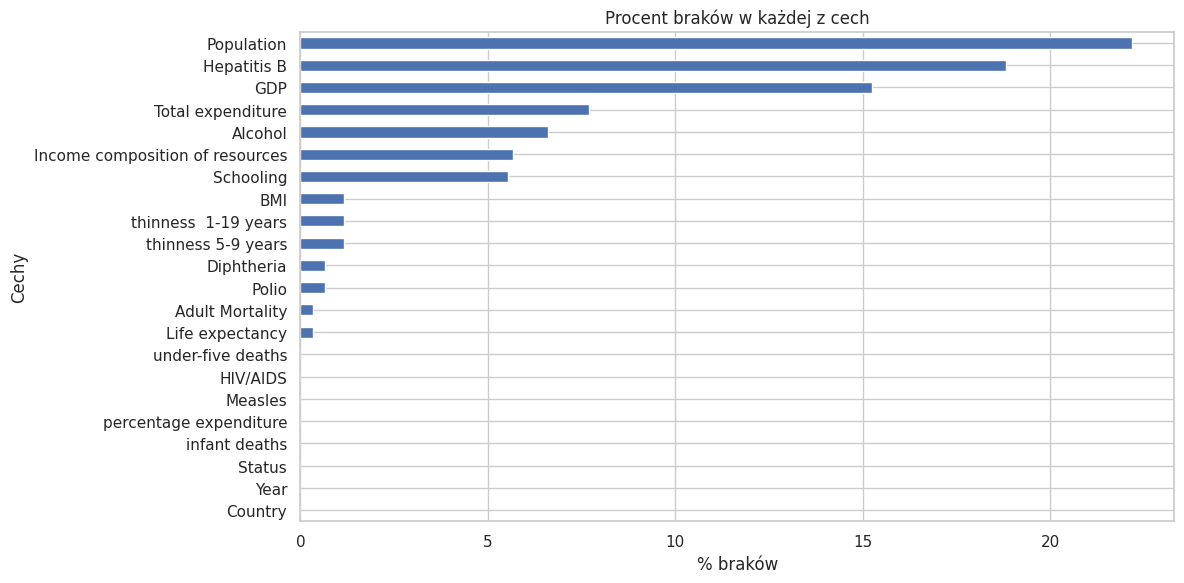

Przed usunieciem:
'Life expectancy' missing %: 0.34
Po usunieciu:
'Life expectancy' missing %: 0.0


In [127]:
missing_pct = df.isna().mean() * 100

plt.figure(figsize=(12, 6))
missing_pct.sort_values(ascending=True).plot(kind='barh',)
plt.xlabel('% braków')
plt.ylabel('Cechy')
plt.title('Procent braków w każdej z cech')
plt.tight_layout()
plt.show()

print('Przed usunieciem:')
print("'Life expectancy' missing %:", round(df["Life expectancy"].isna().mean() * 100, 2))

df_clean = df.dropna(subset=["Life expectancy"])
print('Po usunieciu:')
print("'Life expectancy' missing %:", round(df_clean["Life expectancy"].isna().mean() * 100, 2))

numeric_columns = df_clean.drop(columns=["Country", "Status"]).columns.tolist()

## Braki danych - procentowa analiza

Na podstawie procentowej analizy braków danych w każdej cech określamy:
- największy brak (aż 22.19%) występuje dla populacji
- najmniejszy ale najbardziej uciążliwy brak występuje dla naszej zmeinnej objaśnionej Life expectancy- 0,34%.
- cechy kategoryczne nie posiadają braków

Usunięcie wszystkich wierszy z brakującymi danymi powoduje zbyt dużą stratę informacji(~44%), dlatego usuwamy jedynie wiersze gdzie brakuje naszej kluczowej zmiennej- Life expectancy.

Tak jak zostało wcześniej napisane w eksploracyjnej analizie danych braki możemy zastąpić na wiele sposobów. My zdecydujemy się na sprawdzenie następujących rozwiązań:
- uzupełnianie w obrębie danego kraju po czasie - zastępowanie braku najbliższą znaną wartością
- uzupełnianie braków w kolumnach liczbowych za pomocą mediany
- uzupełnianie w obrębie danego kraju za pomocą interpolacji liniowej - wartości których nie ma są wybierane na podstawie innych wartości danego kraju, chyba że nie ma wartości skrajnych wówczas- uruchamiamy dla tych wartości autouzupełnianie.

In [128]:
def update_life_expectancy_gdp(df, gdp_data_path):
    le_df = df.copy()
    gdp_df_wide = pd.read_csv(gdp_data_path, skiprows=4)
    
    le_df.columns = le_df.columns.str.strip()
    
    country_mapping = {
        'Venezuela (Bolivarian Republic of)': 'Venezuela, RB',
        'Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines',
        'Democratic Republic of the Congo': 'Congo, Dem. Rep.',
        'Republic of Korea': 'Korea, Rep.',
        "Lao People's Democratic Republic": 'Lao PDR',
        'Micronesia (Federated States of)': 'Micronesia, Fed. Sts.',
        'United States of America': 'United States',
        'Slovakia': 'Slovak Republic',
        'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
        'United Republic of Tanzania': 'Tanzania',
        'Egypt': 'Egypt, Arab Rep.',
        'Gambia': 'Gambia, The',
        'Yemen': 'Yemen, Rep.',
        'Somalia': 'Somalia, Fed. Rep.',
        'Kyrgyzstan': 'Kyrgyz Republic',
        "Democratic People's Republic of Korea": "Korea, Dem. People's Rep.",
        'Republic of Moldova': 'Moldova',
        'Bolivia (Plurinational State of)': 'Bolivia',
        'Bahamas': 'Bahamas, The',
        'Congo': 'Congo, Rep.',
        'Iran (Islamic Republic of)': 'Iran, Islamic Rep.',
        'The former Yugoslav republic of Macedonia': 'North Macedonia',
        "Côte d'Ivoire": "Cote d'Ivoire",
        'Saint Kitts and Nevis': 'St. Kitts and Nevis',
        'Saint Lucia': 'St. Lucia',
        'Turkey': 'Turkiye',
        'Swaziland': 'Eswatini'
    }
    
    le_df['Country'] = le_df['Country'].str.strip()
    gdp_df_wide['Country Name'] = gdp_df_wide['Country Name'].str.strip()
    
    le_df['Country_Join'] = le_df['Country'].replace(country_mapping)
    
    #przekształcenie danych GDP z formatu szerokiego na długi
    year_columns = [col for col in gdp_df_wide.columns if col.isdigit()]
    gdp_df_long = gdp_df_wide.melt(
        id_vars=['Country Name'],
        value_vars=year_columns,
        var_name='Year',
        value_name='New_GDP'
    )
    
    gdp_df_long['Year'] = gdp_df_long['Year'].astype(np.float64)
    
    merged = pd.merge(
        le_df,
        gdp_df_long,
        left_on=['Country_Join', 'Year'],
        right_on=['Country Name', 'Year'],
        how='left'
    )
    
    merged['GDP'] = merged['New_GDP']
    
    cols_to_drop = ['Country_Join', 'Country Name', 'New_GDP']
    final_df = merged.drop(columns=cols_to_drop)
    
    return final_df

df_updated = update_life_expectancy_gdp(
    df_clean,
    'GDP_data.csv'
)

prev_nan = df.isna().sum().sum()
droped_nan = prev_nan - df_updated.isna().sum().sum()
print(f"W wyniku uzpełnienia pozbyliśmy się {100*droped_nan/prev_nan:.2f} % braków")

W wyniku uzpełnienia pozbyliśmy się 18.14 % braków


# Usunięcie kolumn o małej korelacji ze zmienną celu

In [129]:
threshold = 0.3

corr = df[numeric_columns].corr()['Life expectancy']
columns = corr[abs(corr) > threshold].index.tolist()

dropcolumns = [x for x in numeric_columns if x not in columns]
numeric_columns = columns
print(f"Kolumny do usuniecia: {dropcolumns}")

df_droped = df_updated.drop(columns=dropcolumns)

prev_nan = df.isna().sum().sum()
droped_nan = prev_nan - df_droped.isna().sum().sum()
print(f"W wyniku usuniecia kolumn o małej korelacji pozbyliśmy się {100*droped_nan/prev_nan:.2f} % braków")

df_droped.isna().sum()

Kolumny do usuniecia: ['Year', 'infant deaths', 'Hepatitis B', 'Measles', 'under-five deaths', 'Total expenditure', 'Population']
W wyniku usuniecia kolumn o małej korelacji pozbyliśmy się 73.66 % braków


Country                              0
Status                               0
Life expectancy                      0
Adult Mortality                      0
Alcohol                            193
percentage expenditure               0
BMI                                 32
Polio                               19
Diphtheria                          19
HIV/AIDS                             0
GDP                                 28
thinness  1-19 years                32
thinness 5-9 years                  32
Income composition of resources    160
Schooling                          160
dtype: int64

# Usuwanie krajów z całkowitymi brakami w kolumnach

In [130]:
df_droped2 = df_droped.copy()
for col in numeric_columns:
    mask = df_droped2.groupby("Country")[col].transform(lambda x: x.isnull().all())
    df_droped2 = df_droped2[~mask].reset_index(drop=True)

df_droped2.isna().sum()

Country                              0
Status                               0
Life expectancy                      0
Adult Mortality                      0
Alcohol                            167
percentage expenditure               0
BMI                                  0
Polio                                8
Diphtheria                           8
HIV/AIDS                             0
GDP                                  4
thinness  1-19 years                 0
thinness 5-9 years                   0
Income composition of resources      0
Schooling                            0
dtype: int64

# Autouzupełnianie

In [131]:
df_filled = df_droped.copy()

df_filled[numeric_columns] = df_filled.groupby("Country")[numeric_columns].ffill().bfill()

print(f"Liczba pozostałych braków:{df_filled.isna().sum().sum()}")


Liczba pozostałych braków:0


# Uzupełnianie za pomocą mediany

In [132]:
df_median = df_droped.copy()

num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

df_median[numeric_columns] = num_imputer.fit_transform(df_median[numeric_columns])

print(f"Liczba pozostałych braków:{df_median.isna().sum().sum()}")

Liczba pozostałych braków:0


# Uzupełnianie za pomocą interpolacji

In [133]:
df_interpolation = df_droped2.copy()

#interpolacja z bfill i ffill na krawędziach
df_interpolation[numeric_columns] = df_interpolation.groupby("Country")[numeric_columns]\
    .transform(lambda g: g.interpolate(method='linear', limit_direction='both'))

print(f"Liczba pozostałych braków:{df_interpolation.isna().sum().sum()}")

Liczba pozostałych braków:0


## 3 Wybór zmiennej objaśnionej

Jako zmienną objaśnioną użyliśmy: **Life expectancy**

Z listy pozostałych cech usunęliśmy cechę Country, aby uniknąć sytuacji gdzie model nauczy się rozpoznawać kraję.

Wybieramy zmienne i cechy dla każdego zbioru danych osobno- każdy zbiór danych ma inne uzupełnianie braków

In [134]:
y_median = df_median["Life expectancy"]

x_median = df_median.drop(columns=["Life expectancy", "Country"])

y_interpolation = df_interpolation["Life expectancy"]

x_interpolation = df_interpolation.drop(columns=["Life expectancy", "Country"])

y_filled = df_filled["Life expectancy"]

x_filled = df_filled.drop(columns=["Life expectancy", "Country"])

# 4 Podział na zbiory treningowy i testowy.

In [135]:
x_train_filled, x_test_filled, y_train_filled, y_test_filled = train_test_split(
    x_filled,
    y_filled,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True
)

print("Treningowy z autouzupełnianiem:", x_train_filled.shape, "Testowy z autouzupełnianiem:", x_test_filled.shape)

x_train_interpolation, x_test_interpolation, y_train_interpolation, y_test_interpolation = train_test_split(
    x_interpolation,
    y_interpolation,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True
)

print("Treningowy z interpolacją:", x_train_interpolation.shape, "Testowy z interpolacją :", x_test_interpolation.shape)

x_train_median, x_test_median, y_train_median, y_test_median = train_test_split(
    x_median,
    y_median,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True
)

print("Treningowy z medianą:", x_train_median.shape, "Testowy z medianą:", x_test_median.shape)

Treningowy z autouzupełnianiem: (2342, 13) Testowy z autouzupełnianiem: (586, 13)
Treningowy z interpolacją: (2188, 13) Testowy z interpolacją : (548, 13)
Treningowy z medianą: (2342, 13) Testowy z medianą: (586, 13)


## 5 Przygotowanie danych

Cecha binarna "Status" została przekształcona w następujący sposób: Developing na 0, a Developed na 1

Po przygotowaniu dane zostały połączone w macierz cech.

In [136]:
def prepare_X_t(x_train: pd.DataFrame, x_test: pd.DataFrame) -> tuple:

    numeric_columns = x_train.select_dtypes(include='number').columns.tolist()

    X_train_status = x_train['Status'].map({'Developing': 0, 'Developed': 1}).to_numpy().reshape(-1, 1)
    X_test_status  = x_test['Status'].map({'Developing': 0, 'Developed': 1}).to_numpy().reshape(-1, 1)

    X_train_num = x_train[numeric_columns].to_numpy()
    X_test_num  = x_test[numeric_columns].to_numpy()

    X_train_t = np.hstack([X_train_num, X_train_status])
    X_test_t  = np.hstack([X_test_num,  X_test_status])

    return X_train_t, X_test_t

X_train_t_filled, X_test_t_filled = prepare_X_t(x_train_filled, x_test_filled)

X_train_t_interpolation, X_test_t_interpolation = prepare_X_t(x_train_interpolation, x_test_interpolation)

X_train_t_median, X_test_t_median = prepare_X_t(x_train_median, x_test_median)


pd.DataFrame([[X_train_t_filled.shape, X_test_t_filled.shape],
             [X_train_t_interpolation.shape, X_test_t_interpolation.shape],
             [X_train_t_median.shape, X_test_t_median.shape]],
             columns=['Treningowy', 'Testowy'],
             index=['ffill/bfill','interpolacja', 'mediana'])


,Treningowy,Testowy
ffill/bfill,"(2342, 13)","(586, 13)"
interpolacja,"(2188, 13)","(548, 13)"
mediana,"(2342, 13)","(586, 13)"


# 6 Dobór cech: lista cech po przygotowaniu danych 

Cechy znajdujące się w  modelu będą takie same dla wszystkich zbiorów (różnice pomiędzy uzupełnianiem braków nie wpływają na cechy)

In [137]:
numeric_columns = x_train_filled.select_dtypes(include='number').columns.tolist()
feature_names = numeric_columns + ['Status']

print(f"liczba cech: {len(feature_names)}")
display(pd.DataFrame({"Cechy": feature_names}))

liczba cech: 13


,Cechy
0,Adult Mortality
1,Alcohol
2,percentage expenditure
3,BMI
4,Polio
5,Diphtheria
6,HIV/AIDS
7,GDP
8,thinness 1-19 years
9,thinness 5-9 years


# 7 Sprawdzenie miary jakości modelu

Najpierw wykonujemy uczenie modelu na zbiorze train, następnie przewidujemy na podstawie zbioru test.

Następnie aby ocenić jakość modelu używamy:
- MAE – średnia wartość bezwzględnego błędu przewidywań (im mniejszy, tym lepiej),
- RMSE – pierwiastek ze średniego kwadratu błędów (im mniejszy, tym lepiej),
- R² – współczynnik determinacji- określa jaka część zmienności danych jest wyjaśniona przez model (im bliżej 1, tym lepiej).

In [138]:
def evaluate_estimator(model, X_train_t, X_test_t, y_train, y_test, fit) -> dict:
    if fit:
        model.fit(X_train_t, y_train)

    y_pred = model.predict(X_test_t)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return {
        "model": model,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
    }

# 8 Testowanie modeli

Modele wybieramy na podstawie błędu RMSE

In [139]:
def evaluate_and_select_best(X_train, X_test, y_train, y_test, dataset_name):
    print(f"\n{"\nSposób uzupełniania:" + dataset_name}")

    lin_model = LinearRegression()
    lasso_cv = LassoCV(eps=0.001, alphas=100, cv=5, random_state=RANDOM_STATE)
    ridge_cv = RidgeCV(alphas=np.logspace(-3, 3, 10), cv=5)
    random_forest = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=RANDOM_STATE)

    scaler = StandardScaler()
    
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    results = [
        evaluate_estimator(lin_model, X_train_scaled, X_test_scaled, y_train, y_test, True),
        evaluate_estimator(lasso_cv, X_train_scaled, X_test_scaled, y_train, y_test, True),
        evaluate_estimator(ridge_cv, X_train_scaled, X_test_scaled, y_train, y_test, True),
        evaluate_estimator(random_forest, X_train, X_test, y_train, y_test, True)

    ]

    results_df = pd.DataFrame(results).sort_values("RMSE")
    display(results_df)

    best_model = results_df.iloc[0]["model"]
    print("Najlepszy wg RMSE:", best_model)

    return best_model, results_df

best_filled, results_filled = evaluate_and_select_best(
    X_train_t_filled, X_test_t_filled, y_train_filled, y_test_filled, "Autouzupełnianie"
)

best_closest, results_closest = evaluate_and_select_best(
    X_train_t_interpolation, X_test_t_interpolation, y_train_interpolation, y_test_interpolation, "Interpolacja"
)

best_median, results_median = evaluate_and_select_best(
    X_train_t_median, X_test_t_median, y_train_median, y_test_median, "Mediana"
)



Sposób uzupełniania:Autouzupełnianie


,model,MAE,RMSE,R2
3,"(DecisionTreeRegressor(max_depth=20, max_featu...",1.052693,1.733753,0.965249
2,"RidgeCV(alphas=array([1.00000000e-03, 4.641588...",3.038052,4.154345,0.800477
1,"LassoCV(alphas=100, cv=5, random_state=42)",3.037199,4.155194,0.800396
0,LinearRegression(),3.042883,4.158855,0.800044


Najlepszy wg RMSE: RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)


Sposób uzupełniania:Interpolacja


,model,MAE,RMSE,R2
3,"(DecisionTreeRegressor(max_depth=20, max_featu...",1.039226,1.729461,0.965659
0,LinearRegression(),2.771421,3.757717,0.837879
2,"RidgeCV(alphas=array([1.00000000e-03, 4.641588...",2.774663,3.759118,0.837758
1,"LassoCV(alphas=100, cv=5, random_state=42)",2.763600,3.760078,0.837676


Najlepszy wg RMSE: RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)


Sposób uzupełniania:Mediana


,model,MAE,RMSE,R2
3,"(DecisionTreeRegressor(max_depth=20, max_featu...",1.070926,1.826234,0.961443
1,"LassoCV(alphas=100, cv=5, random_state=42)",2.945833,4.004141,0.814644
2,"RidgeCV(alphas=array([1.00000000e-03, 4.641588...",2.950899,4.006357,0.814439
0,LinearRegression(),2.954884,4.010013,0.814100


Najlepszy wg RMSE: RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)


# Wnioski

Dane wypełnione przy pomocy miedany globlanej kolumny wykazują najmnijeszy MAE oraz RMSE i największy R². Wynika to z tego, że wartości usupałniane nie posiadają dużych skoków ani ekstremów, więc model uczy się przewidywać bardziej stabilnie.

Pozostałe metody uzupełniania wykorzystują wartości bliższe danemu krajowi, co powoduje, że dane są bardziej rzetelne. Większą skutecznością cechuje się tutaj uzupełnienie za pomocą interpolacji- jest to logiczne ponieważ wówczas mamy wartości pośrednie a nie skrajne.

We wszystkich przypadkach lepszym wyborem okazała się regresja liniowa.

Ponieważ w naszym zbiorze danych występują duże rónicę między skalami poszczególnych cech np. Measles jest rzędu dziesiątek tysięcy a Alcohol od 0 do 1800 wykonaliśmy standaryzację danych, a dopiero poźniej wykonanie modelu, mogliśmy to wykonać, ponieważ standaryzacja nie zmienia wartości względnych, więc MAE, RMSE i R² pozostają takie same.

# 9. Dostrojenie modelu

In [140]:
param_grid = {
    'n_estimators': [200, 250, 300],
    'max_depth': [None, 20, 25, 30],
    'min_samples_split': [2, 5]
}

rf = RandomForestRegressor()
grid_search_interpolation = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
)

grid_search_interpolation.fit(X_train_t_interpolation, y_train_interpolation)

grid_search_median = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
)

grid_search_median.fit(X_train_t_median, y_train_median)

grid_search_filled = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
)

grid_search_filled.fit(X_train_t_filled, y_train_filled)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestRegressor()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [None, 20, ...], 'min_samples_split': [2, 5], 'n_estimators': [200, 250, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is di

In [141]:
print("Interpolacja:")
print(f"Najlepsze parametry: {grid_search_interpolation.best_params_}")
print(f"Najlepszy wynik RMSE: {np.sqrt(-grid_search_interpolation.best_score_)}")

print("\nMediana:")
print(f"Najlepsze parametry: {grid_search_median.best_params_}")
print(f"Najlepszy wynik RMSE: {np.sqrt(-grid_search_median.best_score_)}")

print("\nAutouzupełnianie:")
print(f"Najlepsze parametry: {grid_search_filled.best_params_}")
print(f"Najlepszy wynik RMSE: {np.sqrt(-grid_search_filled.best_score_)}")

Interpolacja:
Najlepsze parametry: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Najlepszy wynik RMSE: 1.9140102853386147

Mediana:
Najlepsze parametry: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Najlepszy wynik RMSE: 1.9439660828863763

Autouzupełnianie:
Najlepsze parametry: {'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 300}
Najlepszy wynik RMSE: 1.9327635182936331


# 9 Pełne wyniki walidacji krzyżowej dla najlepszych modeli

Walidacja krzyżowa pozwala sprawdzić stabilność wyniku.

Wzór: 

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-\hat{y}_i)^2}$$

In [142]:
results_df = pd.DataFrame(grid_search_interpolation.cv_results_)
best_row = results_df.loc[grid_search_interpolation.best_index_]
fold_cols = [col for col in results_df.columns if re.fullmatch('split._test_score', col)]

print("Statystyki najlepszego modelu interpolacja:")
print(f"Mean RMSE: {np.sqrt(-best_row['mean_test_score']):.4f}")
print(f"Std RMSE: {np.sqrt(best_row['std_test_score']):.4f}")
print("\nWyniki RMSE w poszczególnych foldach:")
print(np.sqrt(-best_row[fold_cols].astype(np.float64)))

results_df = pd.DataFrame(grid_search_median.cv_results_)
best_row = results_df.loc[grid_search_median.best_index_]
fold_cols = [col for col in results_df.columns if re.fullmatch('split._test_score', col)]

print("\nStatystyki najlepszego modelu median:")
print(f"Mean RMSE: {np.sqrt(-best_row['mean_test_score']):.4f}")
print(f"Std RMSE: {np.sqrt(best_row['std_test_score']):.4f}")
print("\nWyniki RMSE w poszczególnych foldach:")
print(np.sqrt(-best_row[fold_cols].astype(np.float64)))

results_df = pd.DataFrame(grid_search_filled.cv_results_)
best_row = results_df.loc[grid_search_filled.best_index_]
fold_cols = [col for col in results_df.columns if re.fullmatch('split._test_score', col)]

print("\nStatystyki najlepszego modelu autouzupełnienie:")
print(f"Mean RMSE: {np.sqrt(-best_row['mean_test_score']):.4f}")
print(f"Std RMSE: {np.sqrt(best_row['std_test_score']):.4f}")
print("\nWyniki RMSE w poszczególnych foldach:")
print(np.sqrt(-best_row[fold_cols].astype(np.float64)))

Statystyki najlepszego modelu interpolacja:
Mean RMSE: 1.9140
Std RMSE: 0.6372

Wyniki RMSE w poszczególnych foldach:
split0_test_score    1.908132
split1_test_score    2.079794
split2_test_score    1.812773
split3_test_score    1.791405
split4_test_score    1.963515
Name: 0, dtype: float64

Statystyki najlepszego modelu median:
Mean RMSE: 1.9440
Std RMSE: 0.6566

Wyniki RMSE w poszczególnych foldach:
split0_test_score    2.064341
split1_test_score    2.034460
split2_test_score    1.991736
split3_test_score    1.811483
split4_test_score    1.801668
Name: 8, dtype: float64

Statystyki najlepszego modelu autouzupełnienie:
Mean RMSE: 1.9328
Std RMSE: 0.6290

Wyniki RMSE w poszczególnych foldach:
split0_test_score    2.050097
split1_test_score    2.013614
split2_test_score    1.967813
split3_test_score    1.835203
split4_test_score    1.783277
Name: 14, dtype: float64


# Wnioski

Uzupełnienie danych przy pomocy miedany daje nie co lepsze whyniki niż autuzupełnianie czy też zastosowanie interpolacji.

Natomiast tak samo jak poprzednio interpolacja wykazuję lekko lepsze własności niż przy pomocy autouzupełniania.

Pomimo tego wszystkie trzy metody uzupełniania mają zbliżone RMSE, różnice nie są zbyt duże.

# 10. Sprawdzenie zdolności najlepszych modeli do generalizacji

In [143]:
best_interpolation = grid_search_interpolation.best_estimator_
best_filled = grid_search_filled.best_estimator_
best_median = grid_search_median.best_estimator_

print("Interpolacja")
print(evaluate_estimator(best_interpolation, X_train_t_interpolation, X_test_t_interpolation, y_train_interpolation, y_test_interpolation, False))
print("\nAutouzupełnienie")
print(evaluate_estimator(best_filled, X_train_t_filled, X_test_t_filled, y_train_filled, y_test_filled, False))
print("\nMediana")
print(evaluate_estimator(best_median, X_train_t_median, X_test_t_median, y_train_median, y_test_median, False))

Interpolacja
{'model': RandomForestRegressor(n_estimators=200), 'MAE': 1.037587591240878, 'RMSE': np.float64(1.7004512555870968), 'R2': 0.9668014955763932}

Autouzupełnienie
{'model': RandomForestRegressor(max_depth=25, n_estimators=300), 'MAE': 1.049145461091886, 'RMSE': np.float64(1.7494967187952781), 'R2': 0.9646154922821608}

Mediana
{'model': RandomForestRegressor(max_depth=20, n_estimators=300), 'MAE': 1.0553864723580753, 'RMSE': np.float64(1.7912627200453242), 'R2': 0.9629058462131966}


# 11. Dobór cech modelu

**Tryb backward**

In [144]:
sfs_backward = SequentialFeatureSelector(best_interpolation, 
                                direction='backward', 
                                scoring='neg_root_mean_squared_error',
                                cv=5,
                                tol=0.01)

sfs_backward.fit(X_train_t_interpolation, y_train_interpolation)

,estimator estimator: estimator instanceAn unfitted estimator.,RandomForestR...stimators=200)
,"n_features_to_select n_features_to_select: ""auto"", int or float, default=""auto""If `""auto""`, the behaviour depends on the `tol` parameter:- if `tol` is not `None`, then features are selected while the score change does not exceed `tol`.- otherwise, half of the features are selected.If integer, the parameter is the absolute number of features to select.If float between 0 and 1, it is the fraction of features to select... versionadded:: 1.1 The option `""auto""` was added in version 1.1... versionchanged:: 1.3 The default changed from `""warn""` to `""auto""` in 1.3.",'auto'
,"tol tol: float, default=NoneIf the score is not incremented by at least `tol` between twoconsecutive feature additions or removals, stop adding or removing.`tol` can be negative when removing features using `direction=""backward""`.`tol` is required to be strictly positive when doing forward selection.It can be useful to reduce the number of features at the cost of a smalldecrease in the score.`tol` is enabled only when `n_features_to_select` is `""auto""`... versionadded:: 1.1",0.01
,"direction direction: {'forward', 'backward'}, default='forward'Whether to perform forward selection or backward selection.",'backward'
,"scoring scoring: str or callable, default=NoneScoring method to use for cross-validation. Options:- str: see :ref:`scoring_string_names` for options.- callable: a scorer callable object (e.g., function) with signature ``scorer(estimator, X, y)`` that returns a single value. See :ref:`scoring_callable` for details.- `None`: the `estimator`'s :ref:`default evaluation criterion ` is used.",'neg_root_mean_squared_error'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. In all othercases, :class:`~sklearn.model_selection.KFold` is used. These splittersare instantiated with `shuffle=False` so the splits will be the sameacross calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.",5
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel. When evaluating a new feature toadd or remove, the cross-validation procedure is parallel over thefolds.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until al

In [145]:
selected_features_backward = x_interpolation.columns[sfs_backward.get_support()]
droped_features = [x for x in x_interpolation.columns if x not in selected_features_backward]
print(f"Wybrane cechy: {selected_features_backward}")
print(f"Usuniete cechy: {droped_features}")

Wybrane cechy: Index(['Status', 'Adult Mortality', 'BMI', 'Diphtheria', 'HIV/AIDS', 'GDP', 'thinness  1-19 years', 'thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')
Usuniete cechy: ['Alcohol', 'percentage expenditure', 'Polio']


In [146]:
x_train_transformed = sfs_backward.transform(X_train_t_interpolation)

scores = cross_val_score(best_interpolation, x_train_transformed, y_train_interpolation, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-scores)

print(f"Średnie RMSE dla wybranych cech: {rmse_scores.mean()}")

Średnie RMSE dla wybranych cech: 1.8815675204500582


In [147]:
x_test_transformed = sfs_backward.transform(X_test_t_interpolation)
display(evaluate_estimator(best_interpolation, x_train_transformed, x_test_transformed, y_train_interpolation, y_test_interpolation, True))

{'model': RandomForestRegressor(n_estimators=200),
 'MAE': 1.016365875912408,
 'RMSE': np.float64(1.6871171399963119),
 'R2': 0.9673201074230812}

**Tryb forward**

In [148]:
sfs_forward = SequentialFeatureSelector(best_interpolation, 
                                direction='forward', 
                                scoring='neg_root_mean_squared_error',
                                cv=5,
                                tol=0.01)

sfs_forward.fit(X_train_t_interpolation, y_train_interpolation)

,estimator estimator: estimator instanceAn unfitted estimator.,RandomForestR...stimators=200)
,"n_features_to_select n_features_to_select: ""auto"", int or float, default=""auto""If `""auto""`, the behaviour depends on the `tol` parameter:- if `tol` is not `None`, then features are selected while the score change does not exceed `tol`.- otherwise, half of the features are selected.If integer, the parameter is the absolute number of features to select.If float between 0 and 1, it is the fraction of features to select... versionadded:: 1.1 The option `""auto""` was added in version 1.1... versionchanged:: 1.3 The default changed from `""warn""` to `""auto""` in 1.3.",'auto'
,"tol tol: float, default=NoneIf the score is not incremented by at least `tol` between twoconsecutive feature additions or removals, stop adding or removing.`tol` can be negative when removing features using `direction=""backward""`.`tol` is required to be strictly positive when doing forward selection.It can be useful to reduce the number of features at the cost of a smalldecrease in the score.`tol` is enabled only when `n_features_to_select` is `""auto""`... versionadded:: 1.1",0.01
,"direction direction: {'forward', 'backward'}, default='forward'Whether to perform forward selection or backward selection.",'forward'
,"scoring scoring: str or callable, default=NoneScoring method to use for cross-validation. Options:- str: see :ref:`scoring_string_names` for options.- callable: a scorer callable object (e.g., function) with signature ``scorer(estimator, X, y)`` that returns a single value. See :ref:`scoring_callable` for details.- `None`: the `estimator`'s :ref:`default evaluation criterion ` is used.",'neg_root_mean_squared_error'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. In all othercases, :class:`~sklearn.model_selection.KFold` is used. These splittersare instantiated with `shuffle=False` so the splits will be the sameacross calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.",5
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel. When evaluating a new feature toadd or remove, the cross-validation procedure is parallel over thefolds.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all

In [149]:
selected_features_forward = x_interpolation.columns[sfs_forward.get_support()]
droped_features = [x for x in x_interpolation.columns if x not in selected_features_forward]
print(f"Wybrane cechy: {selected_features_forward}")
print(f"Usuniete cechy: {droped_features}")

Wybrane cechy: Index(['Status', 'Adult Mortality', 'Diphtheria', 'GDP', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources'], dtype='object')
Usuniete cechy: ['Alcohol', 'percentage expenditure', 'BMI', 'Polio', 'HIV/AIDS', 'Schooling']


In [150]:
x_train_transformed = sfs_forward.transform(X_train_t_interpolation)

scores = cross_val_score(best_interpolation, x_train_transformed, y_train_interpolation, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-scores)

print(f"Średnie RMSE dla wybranych cech: {rmse_scores.mean()}")

Średnie RMSE dla wybranych cech: 1.8767472478476435


In [151]:
x_test_transformed = sfs_forward.transform(X_test_t_interpolation)
display(evaluate_estimator(best_interpolation, x_train_transformed, x_test_transformed, y_train_interpolation, y_test_interpolation, True))

{'model': RandomForestRegressor(n_estimators=200),
 'MAE': 1.0271350364963518,
 'RMSE': np.float64(1.712635511448069),
 'R2': 0.9663240361363181}

Wynik

In [152]:
X_train_t_interpolation = sfs_backward.transform(X_train_t_interpolation)
X_test_t_interpolation = sfs_backward.transform(X_test_t_interpolation)

## 11) Analiza błędów: $y_{true}$ vs $y_{pred}$ i reszty

W kroku 11 sprawdzamy, *jakie błędy robi najlepszy model na zbiorze testowym*.

- Liczymy predykcje: $\hat{y} = model.predict(X_{test})$
- Liczymy reszty (błędy): $e = y_{true} - \hat{y}$

Rysujemy 3 proste wykresy diagnostyczne:
1) **$y_{true}$ vs $y_{pred}$ + linia $y=x$**: im bliżej przekątnej, tym lepiej; systematyczne odchylenie = bias.
2) **Histogram reszt**: czy reszty są wokół 0 (brak biasu) i czy są długie ogony (duże pomyłki / outliery).
3) **Reszty vs $y_{pred}$**: czy błąd rośnie dla pewnych zakresów (heteroscedastyczność) lub ma wzór (model liniowy nie łapie zależności).

Na końcu wypisujemy średnią i odchylenie std reszt jako szybkie podsumowanie.

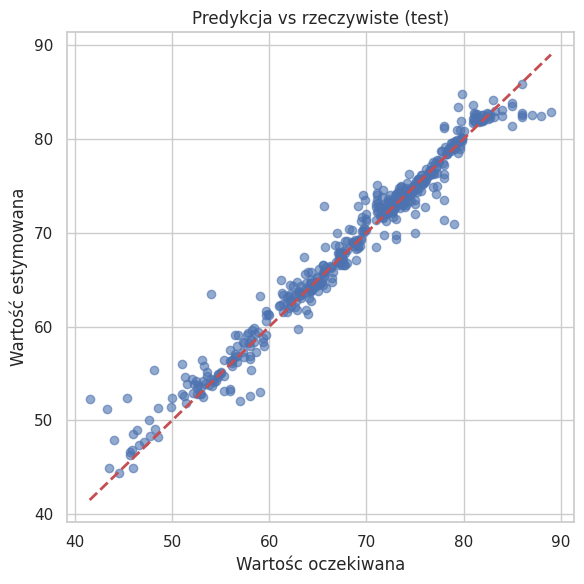

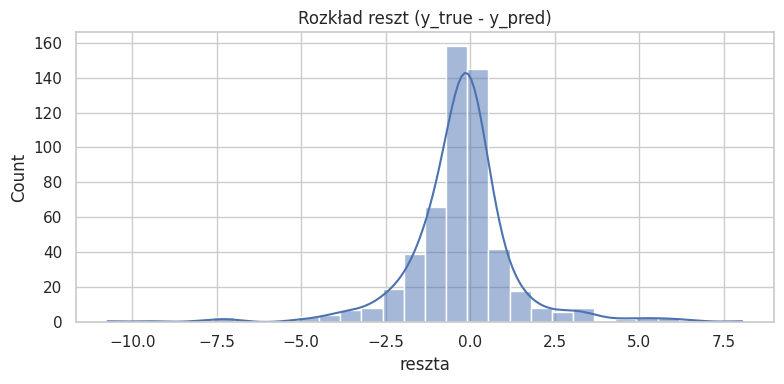

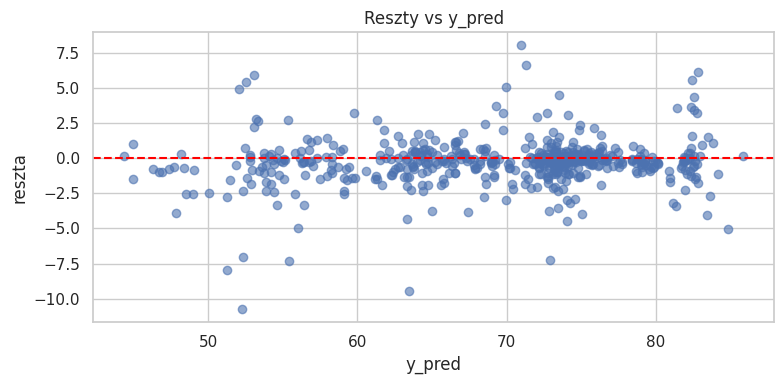

Reszty: średnia= -0.27640419708029257 std= 1.6870538857304753


In [153]:
best_interpolation.fit(X_train_t_interpolation, y_train_interpolation)
y_pred = best_interpolation.predict(X_test_t_interpolation)

errors = y_test_interpolation - y_pred

# Wykres 1: y_true vs y_pred (idealnie punkty leżą na przekątnej)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_interpolation, y_pred, alpha=0.6)
min_v = min(y_test_interpolation.min(), y_pred.min())
max_v = max(y_test_interpolation.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], "r--", linewidth=2)
plt.xlabel("Wartośc oczekiwana")
plt.ylabel("Wartość estymowana")
plt.title("Predykcja vs rzeczywiste (test)")
plt.tight_layout()
plt.show()

# Wykres 2: rozkład reszt (czy jest symetryczny wokół 0?)
plt.figure(figsize=(8, 4))
sns.histplot(errors, kde=True, bins=30)
plt.title("Rozkład reszt (y_true - y_pred)")
plt.xlabel("reszta")
plt.tight_layout()
plt.show()

# Wykres 3: reszty vs y_pred (czy błąd zależy od poziomu predykcji?)
plt.figure(figsize=(8, 4))
plt.scatter(y_pred, errors, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Reszty vs y_pred")
plt.xlabel("y_pred")
plt.ylabel("reszta")
plt.tight_layout()
plt.show()

print("Reszty: średnia=", float(np.mean(errors)), "std=", float(np.std(errors)))

## 12) Ważność cech: współczynniki modelu liniowego

tego nie mamy totalnie bo top jest las losowy, ale moze jest cos podobnego dla tego?

## 14) Sprawdzenie uogólniania: podział po krajach (Country-holdout)

W danych mamy układ **kraj–rok**. Przy zwykłym losowym podziale wierszy ten sam kraj zwykle trafia i do train, i do test, co może **zawyżać wynik** (model „zna” już ten kraj).

Dlatego robimy prosty test uogólniania:
- losujemy ~80% **krajów** do train, a pozostałe kraje zostają w teście,
- trenujemy model na wierszach z krajów-treningowych,
- sprawdzamy metryki na *innych krajach* (bardziej realistycznie).

Ważne: nadal **nie używamy `Country` jako cechy** — `Country` służy tu tylko do zrobienia podziału.

In [154]:
_df = df_interpolation.copy()

# y (target) jako liczby; wiersze z brakującym y usuwamy (nie da się na nich uczyć/oceniać)
y_all = _df["Life expectancy"]

# X: cechy bez Country
X_all = _df.drop(columns=["Life expectancy", "Country"]).reset_index(drop=True)

# grupa = kraj (potrzebne tylko do podziału)
groups = _df["Country"].reset_index(drop=True)

# 1) Losujemy kraje do train/test (80/20)
unique_countries = groups.unique()
rng = np.random.RandomState(RANDOM_STATE)
rng.shuffle(unique_countries)

cut = int(0.8 * len(unique_countries))
train_countries = set(unique_countries[:cut])
is_train = groups.isin(train_countries)

# 2) Składamy zbiory na podstawie krajów
X_train_c = X_all.loc[is_train].reset_index(drop=True)
y_train_c = y_all.loc[is_train].reset_index(drop=True)
X_test_c = X_all.loc[~is_train].reset_index(drop=True)
y_test_c = y_all.loc[~is_train].reset_index(drop=True)

print("Podsumowanie podziału:")
print("- wymiar zbioru treningowego:", X_train_c.shape, "\nwymiar zbioru testowego:", X_test_c.shape)
print("- liczba krajów treningowych:", len(train_countries), "\nliczba krajów testowych:", len(unique_countries) - len(train_countries))

# 3) Przygotowanie danych
X_train_c, X_test_c = prepare_X_t(X_train_c, X_test_c)

# 4) Porównanie modeli
evaluate_and_select_best(X_train_c, X_test_c, y_train_c, y_test_c, "Interpolacja 13 cech")
indexes = [X_all.columns.get_loc(col) for col in selected_features_backward]
evaluate_and_select_best(X_train_c[:,indexes], X_test_c[:,indexes], y_train_c, y_test_c, "Interpolacja wybór cech")
print("\n Najelepszy dotychczas model:")
evaluate_estimator(best_interpolation, X_train_c[:,indexes], X_test_c[:,indexes], y_train_c, y_test_c, True)

Podsumowanie podziału:
- wymiar zbioru treningowego: (2176, 13) 
wymiar zbioru testowego: (560, 13)
- liczba krajów treningowych: 136 
liczba krajów testowych: 35


Sposób uzupełniania:Interpolacja 13 cech


,model,MAE,RMSE,R2
3,"(DecisionTreeRegressor(max_depth=20, max_featu...",2.082523,2.919355,0.901646
1,"LassoCV(alphas=100, cv=5, random_state=42)",2.914288,3.836524,0.830139
2,"RidgeCV(alphas=array([1.00000000e-03, 4.641588...",3.028122,3.940122,0.820841
0,LinearRegression(),3.050320,4.018494,0.813643


Najlepszy wg RMSE: RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)


Sposób uzupełniania:Interpolacja wybór cech


,model,MAE,RMSE,R2
3,"(DecisionTreeRegressor(max_depth=20, max_featu...",2.061709,2.898020,0.903078
1,"LassoCV(alphas=100, cv=5, random_state=42)",2.914641,3.850241,0.828922
2,"RidgeCV(alphas=array([1.00000000e-03, 4.641588...",3.019925,3.953366,0.819635
0,LinearRegression(),3.047204,4.041842,0.811472


Najlepszy wg RMSE: RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)

 Najelepszy dotychczas model:


{'model': RandomForestRegressor(n_estimators=200),
 'MAE': 2.078535714285714,
 'RMSE': np.float64(2.9058234349012753),
 'R2': 0.9025556046696499}

## 15. Przykładowe predykcje modelu

In [155]:
random_indexes = np.random.randint(low=0, high=len(X_test_t_interpolation), size=10)
y_pred = best_interpolation.predict(X_test_t_interpolation[random_indexes,:])
pd.DataFrame(np.array([y_pred,
            y_test_interpolation.iloc[random_indexes],
            (y_pred-y_test_interpolation.iloc[random_indexes])]).T,
            columns=['y_pred', 'y_test', 'błąd'])

,y_pred,y_test,błąd
0,62.4545,58.4,4.0545
1,82.4840,82.7,-0.2160
2,81.5160,81.2,0.3160
3,81.5985,82.0,-0.4015
4,73.2675,73.0,0.2675
5,82.4260,82.4,0.0260
6,54.5085,56.0,-1.4915
7,64.1050,64.0,0.1050
8,71.4760,73.8,-2.3240
9,77.5305,77.9,-0.3695


## 16) Wnioski do sprawozdania 

- **Wyniki są spójne z EDA**: zależności są w dużej mierze liniowe → modele liniowe osiągają sensowne metryki (dla losowego splitu ok. $R^2\approx 0.83$ i RMSE ok. $3.9$ lat).
- **LinearRegression i Ridge dają bardzo podobne rezultaty**: w tej wersji najlepszy wg RMSE na teście jest `LinearRegression` (RMSE ≈ 3.892), a `Ridge(alpha=1.0)` jest minimalnie gorszy (RMSE ≈ 3.896). Różnice są marginalne, więc regularyzacja nie zmienia tu mocno jakości predykcji.
- **Przygotowanie danych jest kluczowe**: imputacja braków + skalowanie cech numerycznych + One-Hot dla `Status` umożliwia trening bez utraty dużej części danych (która wypadłaby przy `dropna`).
- **Współczynniki modelu** (wartości bezwzględne) pozwalają prosto wskazać, które zmienne najsilniej wpływają na przewidywania w modelu liniowym.
- **Test country-holdout** (inne kraje w teście) jest trudniejszy i pogarsza metryki względem losowego splitu: RMSE rośnie do ok. $4.35$, a $R^2$ spada do ok. $0.80$, co jest typowe dla danych kraj–rok.